# Street View Image Downloader with Metadata

This notebook loads the CSV with headings and FOVs, downloads images using the Google Street View API, extracts panorama metadata (including capture dates), and displays them organized by cluster_id with metadata information.

In [1]:
import pandas as pd
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import warnings
from datetime import datetime
from typing import Dict, Any
warnings.filterwarnings('ignore')

# Add src to path to import our modules
sys.path.append('..')
from src.api.streetview_fetcher import StreetViewFetcher
from src.api.streetview import get_panorama_metadata

## Load CSV Data

Load the heading_fov.csv file that contains panorama IDs, cluster IDs, headings, and FOVs.

In [10]:
# CLUSTER_ID = 6422 # dbscan=5meters
# CLUSTER_ID = 8312 # dbscan=2.5meters
CLUSTER_ID = 342

# Load the CSV with headings and FOVs
csv_path = '../data/tresdefebrero/heading_fov.csv'
df = pd.read_csv(csv_path, index_col=0)
df = df[df.cluster_id == CLUSTER_ID]

print(f"Loaded {len(df)} records from {csv_path}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nUnique cluster_ids: {df['cluster_id'].nunique()}")
print(f"Unique pano_ids: {df['pano_id'].nunique()}")

# Display first few rows
df.head(16)

Loaded 12 records from ../data/tresdefebrero/heading_fov.csv

Columns: ['pano_id', 'cluster_id', 'direction', 'heading', 'fov', 'view_id']

Unique cluster_ids: 1
Unique pano_ids: 3


,pano_id,cluster_id,direction,heading,fov,view_id
5972,-cX_K4b2xaMEfE_6uV0BGg,342,N,0.19,90.5,-cX_K4b2xaMEfE_6uV0BGg_N
5973,-cX_K4b2xaMEfE_6uV0BGg,342,E,90.36,89.7,-cX_K4b2xaMEfE_6uV0BGg_E
5974,-cX_K4b2xaMEfE_6uV0BGg,342,S,179.82,89.5,-cX_K4b2xaMEfE_6uV0BGg_S
5975,-cX_K4b2xaMEfE_6uV0BGg,342,W,269.63,90.3,-cX_K4b2xaMEfE_6uV0BGg_W
5976,ahWe81SZOvAk9P2bQX_7PQ,342,N,359.94,89.5,ahWe81SZOvAk9P2bQX_7PQ_N
5977,ahWe81SZOvAk9P2bQX_7PQ,342,E,89.63,90.1,ahWe81SZOvAk9P2bQX_7PQ_E
5978,ahWe81SZOvAk9P2bQX_7PQ,342,S,180.06,90.5,ahWe81SZOvAk9P2bQX_7PQ_S
5979,ahWe81SZOvAk9P2bQX_7PQ,342,W,270.37,89.9,ahWe81SZOvAk9P2bQX_7PQ_W
5980,n7r_9DJH7aVQkmd6-NkcPw,342,N,359.87,90.0,n7r_9DJH7aVQkmd6-NkcPw_N
5981,n7r_9DJH7aVQkmd6-NkcPw,342,E,90.01,90.2,n7r_9DJH7aVQkmd6-NkcPw_E


## Initialize Street View Fetcher

Initialize the StreetViewFetcher with the API key from environment variables.

**Note**: Make sure to run `export GOOGLE_STREET_VIEW_API_KEY=your_api_key_here` in your terminal before running this notebook.

In [11]:
# Initialize the Street View fetcher
try:
    fetcher = StreetViewFetcher()
    api_key = fetcher.api_key  # We'll need this for metadata extraction
    print("✅ StreetViewFetcher initialized successfully")
    print(f"API key loaded: {'Yes' if fetcher.api_key else 'No'}")
except ValueError as e:
    print(f"❌ Error initializing StreetViewFetcher: {e}")
    print("Please run: export GOOGLE_STREET_VIEW_API_KEY=your_api_key_here")
    raise

✅ StreetViewFetcher initialized successfully
API key loaded: Yes


## Panorama Metadata Extraction

Function to extract panorama metadata including capture dates.

In [12]:
def extract_panorama_metadata(pano_id: str, api_key: str) -> Dict[str, Any]:
    """
    Extract panorama metadata including capture date
    
    Parameters
    ----------
    pano_id : str
        Panorama ID
    api_key : str
        Google Street View API key
        
    Returns
    -------
    Dict[str, Any]
        Metadata dictionary with parsed information
    """
    try:
        metadata = get_panorama_metadata(pano_id, api_key)
        
        # Extract and format the date
        date_str = "Unknown"
        if 'date' in metadata:
            date_str = metadata['date']
        elif 'imageDate' in metadata:
            date_str = metadata['imageDate']
        
        # Try to parse and format the date nicely
        formatted_date = "Unknown"
        if date_str != "Unknown":
            try:
                # Handle different date formats
                if '-' in date_str:
                    # Format: YYYY-MM or YYYY-MM-DD
                    if len(date_str.split('-')) == 2:
                        formatted_date = datetime.strptime(date_str, '%Y-%m').strftime('%b %Y')
                    else:
                        formatted_date = datetime.strptime(date_str, '%Y-%m-%d').strftime('%b %Y')
                else:
                    formatted_date = date_str
            except:
                formatted_date = date_str
        
        return {
            'raw_metadata': metadata,
            'date': formatted_date,
            'location': metadata.get('location', {}),
            'status': metadata.get('status', 'UNKNOWN')
        }
        
    except Exception as e:
        print(f"Error extracting metadata for {pano_id}: {e}")
        return {
            'raw_metadata': {},
            'date': 'Error',
            'location': {},
            'status': 'ERROR'
        }

# Test the function with a sample pano_id
if len(df) > 0:
    sample_pano_id = df['pano_id'].iloc[0]
    print(f"Testing metadata extraction with pano_id: {sample_pano_id}")
    sample_metadata = extract_panorama_metadata(sample_pano_id, api_key)
    print(f"Sample metadata: {sample_metadata}")

Testing metadata extraction with pano_id: -cX_K4b2xaMEfE_6uV0BGg
Sample metadata: {'raw_metadata': {'date': '2022-06', 'location': Location(lat=-34.62136602968939, lng=-58.55034640285881), 'pano_id': '-cX_K4b2xaMEfE_6uV0BGg', 'copyright': '© Google'}, 'date': 'Jun 2022', 'location': Location(lat=-34.62136602968939, lng=-58.55034640285881), 'status': 'UNKNOWN'}


## Extract Metadata for All Panoramas

Extract metadata for all unique panorama IDs in the dataset.

In [13]:
# Get unique panorama IDs
unique_pano_ids = df['pano_id'].unique()
print(f"Extracting metadata for {len(unique_pano_ids)} unique panoramas...")

# Extract metadata for all panoramas
metadata_dict = {}
failed_metadata = []

for pano_id in tqdm(unique_pano_ids, desc="Extracting metadata"):
    metadata = extract_panorama_metadata(pano_id, api_key)
    metadata_dict[pano_id] = metadata
    
    if metadata['status'] == 'ERROR':
        failed_metadata.append(pano_id)

# Create a metadata DataFrame for easier handling
metadata_df = pd.DataFrame([
    {
        'pano_id': pano_id,
        'date': metadata['date'],
        'status': metadata['status']
    }
    for pano_id, metadata in metadata_dict.items()
])

print(f"\n📊 Metadata Extraction Summary:")
print(f"✅ Successful: {len(metadata_dict) - len(failed_metadata)}/{len(metadata_dict)}")
print(f"❌ Failed: {len(failed_metadata)}")

# Show date distribution
date_counts = metadata_df['date'].value_counts()
print(f"\n📅 Date Distribution:")
print(date_counts.head(10))

metadata_df.head()

Extracting metadata for 3 unique panoramas...


Extracting metadata: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]


📊 Metadata Extraction Summary:
✅ Successful: 3/3
❌ Failed: 0

📅 Date Distribution:
date
Jun 2022    1
Jan 2014    1
Jun 2019    1
Name: count, dtype: int64


,pano_id,date,status
0,-cX_K4b2xaMEfE_6uV0BGg,Jun 2022,UNKNOWN
1,ahWe81SZOvAk9P2bQX_7PQ,Jan 2014,UNKNOWN
2,n7r_9DJH7aVQkmd6-NkcPw,Jun 2019,UNKNOWN


## Setup Output Directory

Create the directory structure for saving images: `data/image_testing/cluster_id/`

In [14]:
# Create base output directory
base_output_dir = Path('../data/tresdefebrero/image_testing')
base_output_dir.mkdir(parents=True, exist_ok=True)

# Create subdirectories for each cluster_id
unique_clusters = df['cluster_id'].unique()
for cluster_id in unique_clusters:
    cluster_dir = base_output_dir / str(cluster_id)
    cluster_dir.mkdir(exist_ok=True)

print(f"Created directories for {len(unique_clusters)} clusters in {base_output_dir}")

Created directories for 1 clusters in ../data/tresdefebrero/image_testing


## Download Images

Download Street View images for each record in the CSV using the panorama ID, heading, and FOV.

In [15]:
# Function to download and save a single image
def download_image(row, base_dir, size=(640, 640)):
    """
    Download a single Street View image
    """
    try:
        # Create filename using view_id
        filename = f"{row['view_id']}.jpg"
        cluster_dir = base_dir / str(row['cluster_id'])
        filepath = cluster_dir / filename
        
        # Skip if file already exists
        if filepath.exists():
            return True, f"Already exists: {filename}"
        
        # Download image using panorama ID
        img = fetcher.get_panorama_by_id(
            panoid=row['pano_id'],
            heading=row['heading'],
            pitch=0,  # Default pitch
            fov=row['fov'],
            size=size
        )
        
        # Save image
        img.save(filepath, 'JPEG', quality=95)
        return True, f"Downloaded: {filename}"
        
    except Exception as e:
        return False, f"Error downloading {row['view_id']}: {str(e)}"

# Download images with progress bar
print("Starting image downloads...")
results = []
failed_downloads = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Downloading images"):
    success, message = download_image(row, base_output_dir)
    results.append((success, message))
    
    if not success:
        failed_downloads.append((idx, row, message))

# Summary
successful = sum(1 for success, _ in results if success)
total = len(results)

print(f"\n📊 Download Summary:")
print(f"✅ Successful: {successful}/{total} ({successful/total*100:.1f}%)")
print(f"❌ Failed: {len(failed_downloads)}")

if failed_downloads:
    print("\n❌ Failed downloads:")
    for idx, row, message in failed_downloads[:5]:  # Show first 5 failures
        print(f"  - {message}")
    if len(failed_downloads) > 5:
        print(f"  ... and {len(failed_downloads) - 5} more")

Starting image downloads...



📊 Download Summary:
✅ Successful: 12/12 (100.0%)
❌ Failed: 0


## Display Images by Cluster with Metadata

Display all downloaded images organized by cluster_id, with panorama ID and capture date in the titles.

In [16]:
from collections import defaultdict

def display_cluster_images_with_metadata(cluster_id, directions=('N', 'S', 'E', 'W')):
    """
    Display images for a cluster, grouped by direction (e.g., _N, _S), 
    each group in the same column, sorted by date from earliest to latest.
    """
    cluster_dir = base_output_dir / str(cluster_id)
    image_files = list(cluster_dir.glob('*.jpg'))

    if not image_files:
        print(f"No images found for cluster {cluster_id}")
        return

    print(f"\n🖼️  Cluster {cluster_id} - {len(image_files)} images")

    # Group images by direction suffix
    grouped_images = defaultdict(list)
    for img_path in image_files:
        stem = img_path.stem
        if '_' in stem:
            direction = stem.split('_')[-1]
            grouped_images[direction].append(img_path)

    # Sort each direction group by metadata date
    def get_date(img_path):
        view_id = img_path.stem
        pano_id = '_'.join(view_id.split('_')[:-1])
        if pano_id in metadata_dict and 'date' in metadata_dict[pano_id]:
            return metadata_dict[pano_id]['date']
        return '9999-12-31'  # fallback far in the future

    for direction in grouped_images:
        grouped_images[direction] = sorted(grouped_images[direction], key=get_date)

    # Select only specified directions, preserve order
    ordered_dirs = [d for d in directions if d in grouped_images]
    max_len = max(len(grouped_images[d]) for d in ordered_dirs)

    n_rows = max_len
    n_cols = len(ordered_dirs)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

    # Normalize axes access
    if n_rows == 1 and n_cols == 1:
        axes = [[axes]]
    elif n_rows == 1:
        axes = [axes]
    elif n_cols == 1:
        axes = [[ax] for ax in axes]
    else:
        axes = axes

    for col, direction in enumerate(ordered_dirs):
        images = grouped_images[direction]
        for row in range(n_rows):
            ax = axes[row][col]
            if row < len(images):
                img_path = images[row]
                img = Image.open(img_path)
                ax.imshow(img)

                view_id = img_path.stem
                pano_id = '_'.join(view_id.split('_')[:-1])
                img_id = img_path.name.replace('.jpg','')

                date_info = metadata_dict.get(pano_id, {}).get('date', 'Unknown Date')
                title = f"{img_id}\n{date_info}"
                ax.set_title(title, fontsize=10, pad=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()



🖼️  Cluster 342 - 12 images


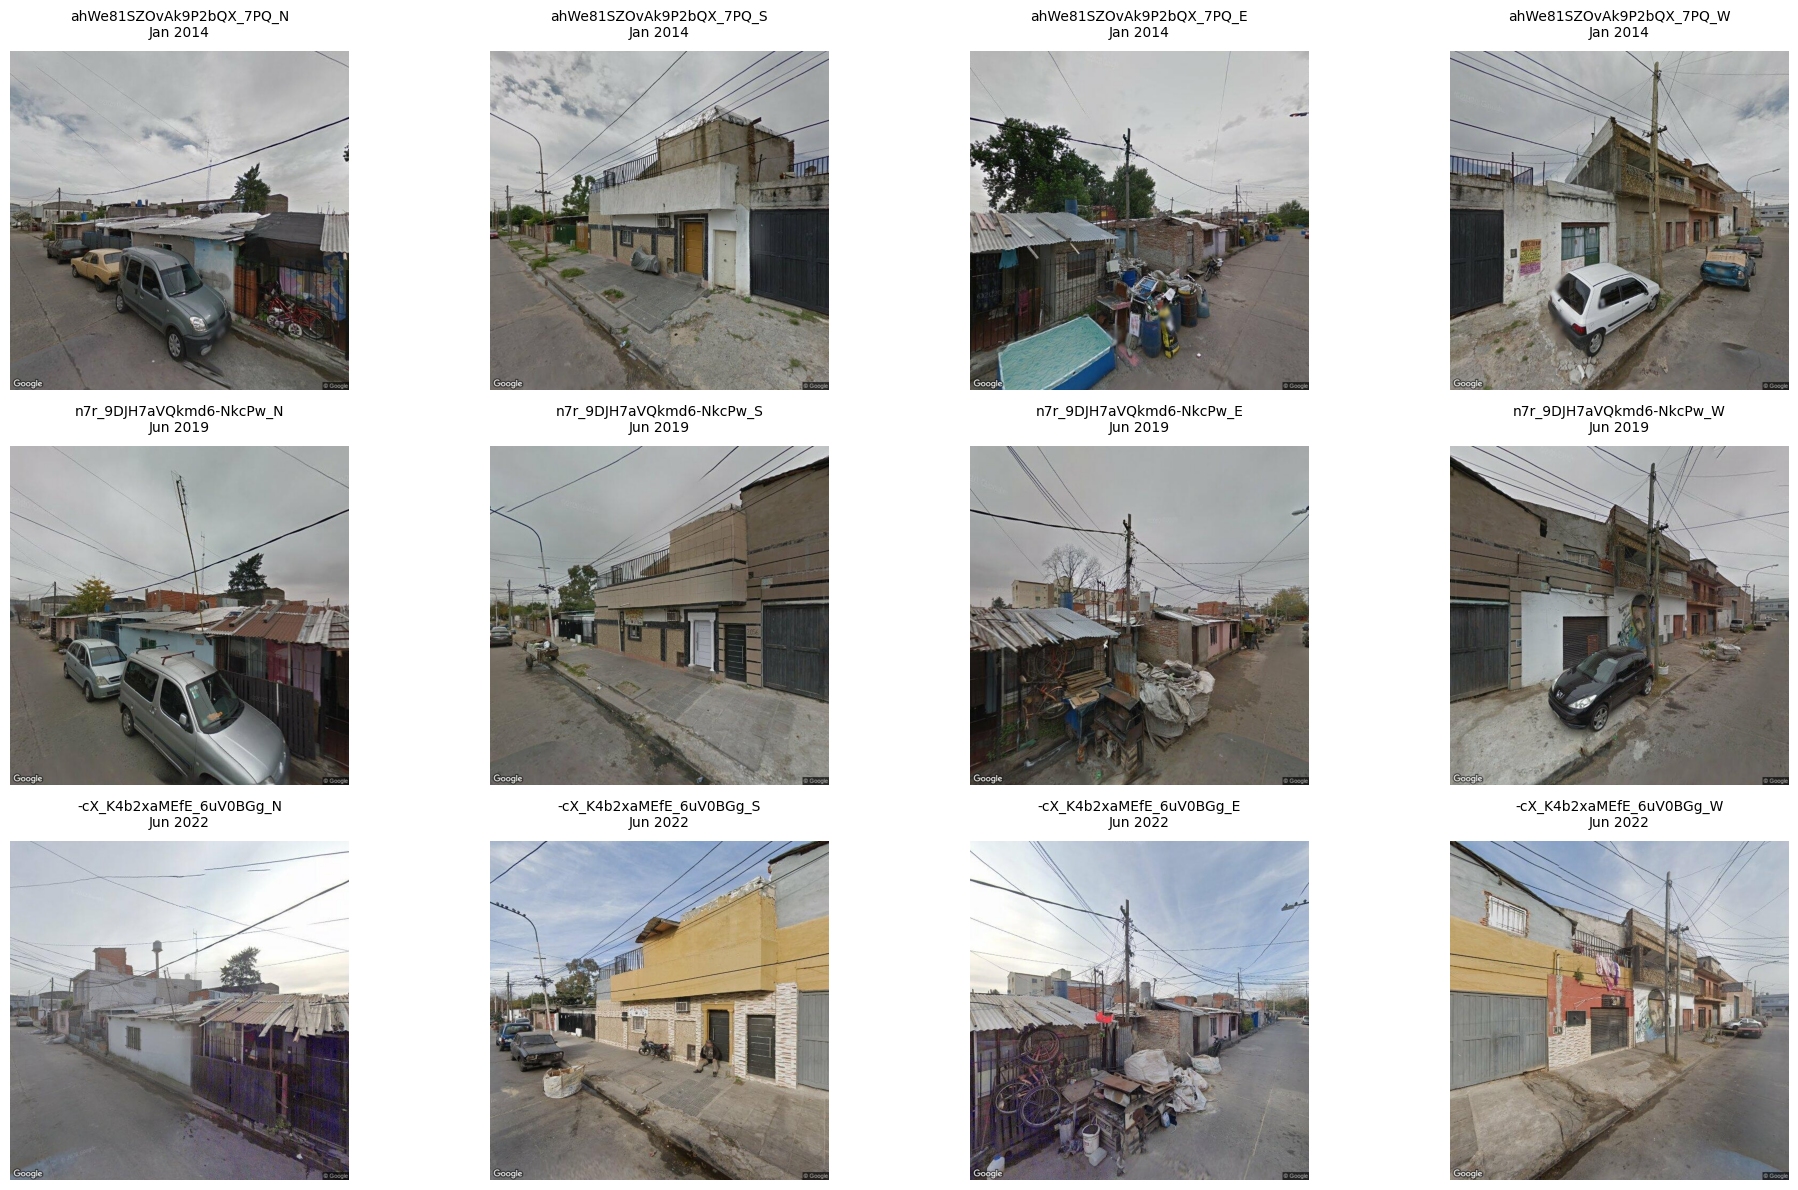

In [17]:
display_cluster_images_with_metadata(CLUSTER_ID)